# Self-Attention

sequential processing이나 recurrent connections에 의존하지 않고, 입력 토큰 간의 거리를 직접 처리하고 이해할 수 있게끔 하는 Self Attention을 기반. 

대용량 세트에서 효율적. 기계 번역 등의 작업에서 적합. 장기적 종속성을 포함하는 작업에 주로 사용.

Auto - Encoding, Auto - Regressive

models :

BERT : 인코더, 오토 인코딩, 양방향 학습

GPT : 디코더, 자기회귀, 단방향 학습

BART : 인코더+디코더, 오토인코딩+자기회귀, 복합 학습

ELECTRA : 디코더+판별기, 오토인코딩+대체토큰탐지, 양방향 학습

T5 : 인코더+디코더, 오토인코딩+자기회귀+처리작업학습, 양방향 학습

## Transformers

Attention Mechanism. Sequence Embedding을 표현.

기존 순환 싱경망 기반 모델보다 학습 속도가 빠르고 병렬 처리가 가능. 따라서, 대규모 데이터세트에서 높은 성능을 보임. 

임베딩 과정에서 문장의 전체 정보를 고려하기 때문에, 문장 길이가 길어져도 성능을 유지.

### Multi Head Attention

input sequence에서 query, key, value 벡터를 정의하여 입력 시퀀스들의 관계를 셀프어텐션하는 벡터 표현 방식. 

해당 과정에서 쿼리와 각 키의 유사도를 계산, 해당 유사도를 가중치로 사용하여 값 벡터를 환산

순방향 신경망은 해당 과정에서 산출된 임베딩 벡터를 더욱 고도화하기 위해 사용. 해당 신경망은 복수 선형 계층으로 구성.

순방향 신경망의 구조와 동일하게 입력 벡터와 가중치를 곱하고 편향을 더해 활성화 함수로 적용.

입력 시퀀스를 Source와 Target으로 나누어 처리. 영어를 한글로 번역하는 경우, 생성 언어인 한글을 target, 참조 언어인 영어를 source(본디 번역을 위해 만들어진 알고리즘이므로 위 구조가 타당)

인코더는 source sequence data를 Positional Encoding된 입력 임베딩으로 표현하여 트랜스포머 블록의 출력 벡터를 생성. 해당 벡터는 입력 시퀀스 데이터의 관계를 잘 표현 가능하게 구성.

디코더도 인코더와 유사하게 transformer block으로 구성되어 있으나, Mastked Multi-Head Attention을 사용하여 타깃 시퀀스 데이터를 순차 생성. 

## 입력 임베딩 / 위치 인코딩

transformer 모델에서 입력 시퀀스의 각 단어는 임베딩 처리되어 벡터 형태로 변환. Transformer 모델은 순환 신경망과 달리, 입 력 시퀀스를 병렬 구조로 처리하기 때문에, 단어의 순서 정보를 제공하지 아니함.

따라서, 위치 정보를 임베딩 벡터에 추가하여 단어의 순서 정보를 모델에 반영. 위치 인코딩은 이를 위한 방식

위치 인코딩 벡터는 sin / cos 함수를 이용하여 생성. 이를 통해 임베딩 벡터와 위치 정보가 결합된 최종 입력 벡터를 생성.

위치 인코딩 벡터를 추가하여 모델은 단어의 순서 정보를 학습 가능하게 됨.

위치 인코딩은 각 토큰의 위치를 각도로 표현하여 sin 함수와 cos 함수로 위치 인코딩 벡터를 계산. 

In [1]:
import torch
import math
from torch import nn
from matplotlib import pyplot as plt

In [5]:
class positional_encoding(nn.Module):
    def __init__(self, d_model, max_len, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p = dropout)
        
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )
        
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position*div_term)
        pe[:, 0, 1::2] = torch.cos(position*div_term)
        self.register_buffer('pe', pe) # 모델이 매개변수를 갱신하지 않도록 설정
        
    def forward(self, x):
        x = x+self.pe[:, x.size(0)]
        return self.dropout(x)

In [6]:
encoding = positional_encoding(d_model = 128, max_len = 50)

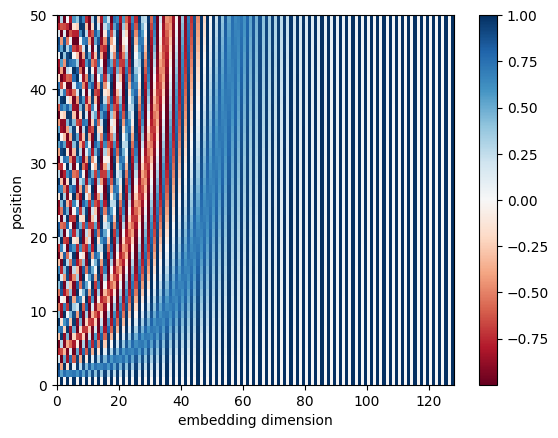

In [8]:
plt.pcolormesh(encoding.pe.numpy().squeeze(), cmap='RdBu')
plt.xlabel('embedding dimension')
plt.xlim((0, 128))
plt.ylabel('position')
plt.colorbar()
plt.show()

## 특수 토큰

단어 토큰이나 특수 토큰을 활용하여 문장을 표현. 해당 특수 토큰은 입력 시퀀스의 처음과 끝을 나타내거나, masking 영역으로 활용

e.g. 번역 모델에서는 디코더의 입력 시퀀스에서 현재 위치 이후의 토큰을 마스크해서 이전 토큰만을 참조.

BOS: Beginning of Sentence

EOS: End of Sentence

UNK: Unknown

PAD: padding

## TF Encoder

입력 시퀀스를 받아 복수 계층으로 구성된 인코딩 계층을 거쳐 연산을 수행. 각 계층은 멀티 헤드 어텐션과 순방향 신경망으로 구성.

인코더 계층에서 위치 정보 반영을 위해 위치 임베딩 벡터를 입력 벡터에 합산. 산출된 계층의 출력은 디코더 계층으로 전달. 

TF 인코더는 위치 인코딩이 적용된 소스 데이터의 입력 임베딩을 입력받음. MHA 단계에서 입력 텐서 차원이 [N, s, d]라고 한다면, 입력 임베딩은 선형 변환을 통하여 세개의 임베딩 벡터를 생성. 각 Query(Q), Key(K), Value(V) 벡터로 정의

Q: 현재 시점에서 참조하고자 하는 정보의 위치. 인코더의 각 시점마다 생성.

K: 쿼리 벡터와의 비교 대상. 입력 시퀀스에서 탐색되는 벡터. 인코더의 각 시점에서 생성

V: Q와 K로 생성된 어텐션 스코어를 얼마나 반영할지 설정하는 가중치.

$\text{attention score}(v^q, v^k) = \text{softmax}\left(\frac{(v^q)^T \times v^k}{\sqrt{d}}\right)$

Multi-head: 셀프 어텐션의 복회 수행을 통한 복수의 헤드 생성. 

N, s, d개의 텐서에 k개의 셀프 어텐션 벡터를 생성할 때, 헤드에 대한 차원 축을 생성하여 N, k, S, d/k 텐서 형태를 구성. 해당 텐서는 k개의 셀프 어텐션된 N, S, d/k 텐서를 의미

순방향 신경망은 선형 임베딩과 ReLU로 이루어진 인공신경망, 혹은 1차원 합성곱이 주로 사용.

TF 인코더는 복수의 TF encoder block으로 구성. 이전 블록에서ㅓ 출력된 벡터는 다음 블록의 입력으로 전달되어, 인코더 블록을 통과하며 점차 입력 시퀀스의 정보가 추상화.

인코더 블록에서 출력된 벡터는 디코더에서 사용. 디코더의 MHA 모듈에서 참조되는 키, 값, 벡터로 활용.

## TF Decoder

위치 인코딩이 적용된 target data의 입력 임베딩을 입력받고, 디코더에 위치정보를 추가함으로써 디코더가 입력 시퀀스의 순서 정보를 학습할 수 있게끔 함.

인코더의 MHA 모듈은 Casuality를 반영한 Masked MHA 모듈로 대체(이하 MMHA). MMHA 모듈은 인코더의 MHA 모델과 유사하나, 어텐션 스코어 맵을 계산할 때 쿼리 벡터가 해당하는 순서의 키 벡터만을 바라볼 수 있도록 마스크를 씌움. 해당 마스크를 적용하면 self attention에서 현재 위치 이전의 단어들만 참조할 수 있게 되며, 인과성이 보장.

MMHA 어텐션 모듈에서는 마스크 영역에 -inf 마스크를 더함으로써 해당 영역의 attention score값을 0에 가깝게 만들어 줄 수 있음.

해당 방식으로, MMHA 모듈은 인코더의 멀티 헤드 어텐션 모듈과 유사하나, 인과성을 보장하며 self attention을 수행할 수 있게 해 줌.

decoder의 MHA에서는 타깃 데이터가 쿼리 벡터로 사용되며, 인코더의 소스 데이터가 키와 값 벡터로 사용. 

따라서, 쿼리 벡터는 타깃 데이터의 위치 정보를 포함한 입력 임베딩과 위치 인코딩을 더한 벡터

쿼리, 키, 값 벡터를 이용하여 attention score map을 계산 후, softmax 함수를 적용해 어텐션 가중치를 구함. 최종적으로, attention 가중치와 값 벡터를 가중합해 MHA의 출력 벡터를 구함.

In [8]:
import torchtext
from torchtext.datasets import Multi30k
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import spacy

In [9]:
def generate_tokens(text_iter, language):
    language_index = {src_language: 0, tgt_language: 1}
    
    for text in text_iter:
        yield token_transform[language](text[language_index[language]])
        

In [10]:
src_language = 'de'
tgt_language = 'en'

unk_idx, pad_idx, bos_iidx, eos_idx = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

In [20]:
token_transform = {
    src_language: get_tokenizer('spacy', language='de_core_news_sm'),
    tgt_language: get_tokenizer('spacy', language='en_core_web_sm'),
}
print('token_transform:')
print(token_transform)

token_transform:
{'de': functools.partial(<function _spacy_tokenize at 0x00000279A80C6B60>, spacy=<spacy.lang.de.German object at 0x00000279B118EE90>), 'en': functools.partial(<function _spacy_tokenize at 0x00000279A80C6B60>, spacy=<spacy.lang.en.English object at 0x00000279AE41AB90>)}


In [16]:
vocab_transform = {}
for language in [src_language, tgt_language]:
    train_iter = Multi30k(split='train', language_pair = (src_language, tgt_language))
    vocab_transform[language] = build_vocab_from_iterator(
        generate_tokens(train_iter, language),
        min_freq = 1,
        specials = special_symbols,
        special_first = True
    )

In [18]:
for language in [src_language, tgt_language]:
    vocab_transform[language].set_default_index(unk_idx)

In [19]:
print('vocab_transform:')
print(vocab_transform)

vocab_transform:
{'de': Vocab(), 'en': Vocab()}
